## Michael Beven - 455613
## University of Chicago - Financial Mathematics
## FINM 33150 - Quantitative Strategies and Regression
## Homework 5

===================================

**First we set up our notebook:**

In [38]:
#~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*#
# Michael Beven                                        #
# University of Chicago - Financial Mathematics        #
# FINM 33150 - Quantitative Strategies and Regression  #
# Homework 4                                           #
#~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*#

##########################
# ipython notebook setup #
##########################

import pandas as pd
import numpy as np
from scipy.stats import norm
import Quandl
import keyring as kr # hidden password
key = kr.get_password('Quandl','mbeven')
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 82)
pd.set_option('precision', 6)

**Next we set up the start and end dates of analysis, as well as some other variables such as the strike and hedge rule parameters:**

In [39]:
##############
# parameters #
##############

start_date = '2014-09-29'
end_date = '2014-10-31'
K = 1860
D = 0.04 #position delta threshold for hedge
M = 160 #hedge every M minutes
T = 90000 #hedge every T trades

**Now we have to obtain the data.  Brian Boonstra has provided some functions to extract necessary high frequency data:**

In [40]:
#################################
# HFT data extracting functions #
#################################

useful_info_fields = {
    '107': 'SecurityDesc',
    '268': 'NoMDEntries', # number of entries
    '269': 'MDEntryType', # 0=Bid, 1=Offer, 2=Trade
    '270': 'MDEntryPx', # Price
    '279': 'MDUpdateAction', 
    '35': 'MsgType',
    '48': 'SecurityID',
    '52': 'SendingTime',
    '75': 'TradeDate',
    # The following are trickier to parse due to repeating according to entry types
    #'1020': 'TradeVolume',
    #'1023': 'MDPriceLevel',
    #'271': 'MDEntrySize', 
    #'277': 'TradeCondition', 
}

def check_equal(iterator):
    try:
        iterator = iter(iterator)
        first = next(iterator)
        return all(first == rest for rest in iterator)
    except StopIteration:
        return True
        
def fields_in(line):
    """
    Parse a FIX message line into a list of dicts, each 
     one representing a market data update
    """
    f = {}
    group_count = None
    observed_group_count = 1
    field_values = [f.split("=") for f in line.split("\x01") if f]
    # Unused, but parse the official mkt update count
    for field,field_value in field_values:
        if field=='268':
            group_count = int(field_value)
    # Record field values
    for field,field_value in field_values:
        if field in useful_info_fields:
            info_field = useful_info_fields[field]
            if info_field in f:
                if isinstance(f[info_field],list):
                    # This field has already been given to us more than once.  Append to the list.
                    f[info_field].append(field_value)
                else:
                    # We have seen this field before and now are seeing it a second time.  Turn it into
                    #  a list
                    existing = f[info_field]
                    f[info_field] = [existing, field_value]
            else:
                # We never saw this field before.  Record its value.
                f[info_field] = field_value
    # Find out how many market updates this message contained
    for field,field_value in f.items():
        if isinstance(field_value,list):
            if check_equal(field_value):
                # Don't bother with cases where all updates had the same value
                f[field] = field_value[0]
            else:
                # Differing values in updates.  Count them.
                num_this_group = len(field_value)
                # Safety check
                if observed_group_count>1 and num_this_group!=observed_group_count:
                    print("Surprise got %d not %d from %s=%s\n%s\n%s\n-------------------------"%(
                            num_this_group,observed_group_count,field,field_value,
                            ' | '.join(line.split("\x01")),
                            ' | '.join(sorted(line.split("\x01"))),
                        ))
                else:
                    observed_group_count = max(observed_group_count,num_this_group)
    # Safety checks
    for field,field_value in f.items():
        if isinstance(field_value,list) and len(field_value)!=observed_group_count:
            print("Error: saw %d values for %s but observed_group_count was %s\n%s"%(
                len(field_value),field,observed_group_count,sorted(field_values) ))
    # Create list of market updates from message field lists
    if group_count and group_count>1:
        gf = [f.copy() for i in range(group_count)]
        for field,field_value in f.items():
            if isinstance(field_value,list):
                for j in range(group_count):
                    gf[j][field] = field_value[j]
    else:
        gf = [f]
    return gf
    
def parse_timestamp(s):
    dt_args = [int(x) for x in (s[:4],s[4:6],s[6:8],s[8:10],s[10:12],s[12:14],s[14:])]
    dt_args[-1] *= 1000
    return datetime.datetime(*tuple(dt_args))    
    
def get_dense(desc,subsample_file):
    dense_trade_prices_list = []
    N = 0
    with open(subsample_file,"rt") as ssfile:
        for line in ssfile:
            fields_list = fields_in(line.strip())
            for fields in fields_list:
                if desc==fields.get('SecurityDesc') and '2'==fields.get('MDEntryType'):
                    price_observed = 0.01*float(fields['MDEntryPx'])
                    t = parse_timestamp(fields['SendingTime'])
                    dense_trade_prices_list.append((t,price_observed))
                    N += 1
    print("Found %d"%N)
    return dense_trade_prices_list
    
def get_dense_frame(desc,subsample_file):
    dense_list = get_dense(desc,subsample_file)
    dense_frame = pd.DataFrame(dense_list,
                                    columns=("Timestamp","Trade"))
    dense_frame.set_index(["Timestamp"], inplace=True)
    dense_prices = dense_frame["Trade"]
    return dense_prices   

**The necessary data is then loaded into Python.  The printed notes show the amount of trades in futures then options of each week in order:**

In [4]:
########
# data #
########

rf = Quandl.get('FED/RILSPDEPM01_N_B',authtoken=key,trim_start=start_date,trim_end=end_date,returns="pandas")
owf = Quandl.get('OWF/CME_ES_ES_X2014_IVM',authtoken=key,trim_start=start_date,trim_end=end_date,returns="pandas")
subsample_20140929_20141003_ESZ4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20140929_20141003_ESZ4'
subsample_20140929_20141003_ESX4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20140929_20141003_ESX4'
subsample_20141006_20141010_ESZ4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141006_20141010_ESZ4'
subsample_20141006_20141010_ESX4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141006_20141010_ESX4'
subsample_20141013_20141017_ESZ4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141013_20141017_ESZ4'
subsample_20141013_20141017_ESX4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141013_20141017_ESX4'
subsample_20141020_20141024_ESZ4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141020_20141024_ESZ4'
subsample_20141020_20141024_ESX4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141020_20141024_ESX4'
subsample_20141027_20141031_ESZ4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141027_20141031_ESZ4'
subsample_20141027_20141031_ESX4 = '/Volumes/VERBATIM HD/Regression/XCME_MD_ES_20141027_20141031_ESX4'
dense_trade_prices_wk1 = get_dense_frame(desc='ESZ4',subsample_file=subsample_20140929_20141003_ESZ4)
dense_opt_prices_wk1 = get_dense_frame(desc='ESX4 P1860',subsample_file=subsample_20140929_20141003_ESX4)
dense_trade_prices_wk2 = get_dense_frame(desc='ESZ4',subsample_file=subsample_20141006_20141010_ESZ4)
dense_opt_prices_wk2 = get_dense_frame(desc='ESX4 P1860',subsample_file=subsample_20141006_20141010_ESX4)
dense_trade_prices_wk3 = get_dense_frame(desc='ESZ4',subsample_file=subsample_20141013_20141017_ESZ4)
dense_opt_prices_wk3 = get_dense_frame(desc='ESX4 P1860',subsample_file=subsample_20141013_20141017_ESX4)
dense_trade_prices_wk4 = get_dense_frame(desc='ESZ4',subsample_file=subsample_20141020_20141024_ESZ4)
dense_opt_prices_wk4 = get_dense_frame(desc='ESX4 P1860',subsample_file=subsample_20141020_20141024_ESX4)
dense_trade_prices_wk5 = get_dense_frame(desc='ESZ4',subsample_file=subsample_20141027_20141031_ESZ4)
dense_opt_prices_wk5 = get_dense_frame(desc='ESX4 P1860',subsample_file=subsample_20141027_20141031_ESX4)

Found 1852440
Found 6
Found 3636111
Found 87
Found 1422524
Found 15
Found 3026349
Found 248
Found 2747508
Found 98


**I looked through the data to find the day with many trades (considering both options and futures) to perform my initial analysis.  This turned out to be day 21 of the month, which is in week 4 data.**  


**First we must choose the buying and selling times of the option.  By the assignment guidelines, I have written code such that the first option traded after 08:45 is sold and the last option price before 15:00 is bought.  This then forms the structure of our data frame:**

In [41]:
############
# analysis #
############

options = dense_opt_prices_wk4[(dense_opt_prices_wk4.index.day == 21) & (dense_opt_prices_wk4.index.time >= datetime.time(8,45,0,0)) & (dense_opt_prices_wk4.index.time <= datetime.time(15,0,0,0))]
df = dense_trade_prices_wk4[(dense_trade_prices_wk4.index.day == 21) & (dense_trade_prices_wk4.index >= datetime.datetime.fromtimestamp(options.index[0].timestamp())) & (dense_trade_prices_wk4.index <= datetime.datetime.fromtimestamp( options.index[-1].timestamp()))]
df = pd.DataFrame(df)

**Next, the hedging amount must be set up.  The OWF at the money options are used for implied volatility, and the time to maturity is set based on the day count convention of 365 days.  ```rf``` (risk-free rate) is sourced separately from Quandl (see ```# data #```).  Concordantly, delta can be calculated for hedging.  I have not used gamma for hedging - using gamma and the futures price can be done as an approximate quick way of delta hedging, but using the vectorization of Pandas my code runs quite quickly:**

In [42]:
df['sig'] = owf.ix['2014-10-21'].AtM # at the money vol
df['tau'] = owf.ix['2014-10-21'].DtE/365 # time to maturity
df['rf'] = rf.ix['2014-10-21'].Value/100 # risk free rate
df['d1'] = (np.log(df.Trade/K) + df.tau*(df.rf+0.5*df.sig**2))/(df.sig*np.sqrt(df.tau))
df['delta'] = norm.cdf(df.d1) - 1 # for hedging

**Let's first run the delta strategy, i.e. if the delta of the option is far enough from our current hedging delta by some limit (say ```D```), then we re-hedge using the new delta:**


**NOTE: one loop is used here, which is slightly costly for computations.  This loop takes ~30 seconds to run depending on the day**

In [43]:
df['hedgeD'] = 0 # set 0 column
df['hedgeD'].ix[0] = df.delta[0] # initially hedge option at first delta
for i in range(1,len(df)):
    if np.abs(df.hedgeD[i-1] - df.delta[i]) > D: # if delta of new trade is different enough from current hedging delta
        df.hedgeD[i] = df.delta[i] # re-hedge using new delta
    else:
        df.hedgeD[i] = df.hedgeD[i-1] # keep old delta
df['hedgeD_CF'] = df.hedgeD*df.Trade - df.shift(1).hedgeD*df.shift(1).Trade # PnL between trades
df.hedgeD_CF.ix[0] = options[0] # money by selling option
df['hedgeD_CF_cum'] = np.cumsum(df.hedgeD_CF) # cumulative cash flows
df.hedgeD_CF_cum.ix[-1] = df.hedgeD_CF_cum.ix[-1] - options[-1] # money by buying option

**Next, let's run the time strategy, i.e. re-hedge every ```M``` minutes with the new delta at that time:**

In [44]:
df['time'] = df.index # create time column from index    
df['timediff'] = (df.time - df.time.shift(1)).astype('timedelta64[ms]') # find difference in time of trades
df['cumdiff'] = np.cumsum(df.timediff)/1000/60//M # mark where M minutes have passed
df.cumdiff[df.cumdiff == df.cumdiff.shift(1)] = np.nan # remove other cumdiff values that don't mark anything
df['hedgeM'] = np.nan # set empty column
df['hedgeM'].ix[0] = df.delta[0] # initially hedge option at first delta
df.hedgeM[np.isnan(df.cumdiff) == False] = df.delta # place delta at markers
df.hedgeM = df.hedgeM.fillna(method='ffill') # fill delta until delta changes
df['hedgeM_CF'] = df.hedgeM*df.Trade - df.shift(1).hedgeM*df.shift(1).Trade # PnL between trades
df.hedgeM_CF.ix[0] = options[0]  # money by selling option
df['hedgeM_CF_cum'] = np.cumsum(df.hedgeM_CF) # cumulative cash flows
df.hedgeM_CF_cum.ix[-1] = df.hedgeM_CF_cum.ix[-1] - options[-1] # money by buying option

**Finally, we run the number of trades strategy, i.e. re-hedge every ```T``` trades with the new delta at that trade:**

In [45]:
df['hedgeTpoint'] = np.where(df.index)[0]//T # number the trades and find every T'th modulo
df.hedgeTpoint[df.hedgeTpoint == df.hedgeTpoint.shift(1)] = np.nan  # remove other values that don't mark anything
df['hedgeT'] = np.nan # set empty column
df['hedgeT'].ix[0] = df.delta[0] # initially hedge option at first delta
df.hedgeT[np.isnan(df.hedgeTpoint) == False] = df.delta # place delta at markers
df.hedgeT = df.hedgeT.fillna(method='ffill')  # fill delta until delta changes
df['hedgeT_CF'] = df.hedgeT*df.Trade - df.shift(1).hedgeT*df.shift(1).Trade # PnL between trades
df.hedgeT_CF.ix[0] = options[0] # money by selling option
df['hedgeT_CF_cum'] = np.cumsum(df.hedgeT_CF) # cumulative cash flows
df.hedgeT_CF_cum.ix[-1] = df.hedgeT_CF_cum.ix[-1] - options[-1] # money by buying option

**One other strategy we are interested in, is the combined strategy.  For my approach of the combination strategy, I have decided to take the average delta at each trade of the three strategies.  This makes sense - the extreme deltas that may be produced by the strategies will be 'averaged out' to potentially decrease riskiness.**

In [46]:
df['hedgeC'] = (df.hedgeD + df.hedgeM + df.hedgeT)/3 # combination of hedge strategies
df['hedgeC_CF'] = df.hedgeC*df.Trade - df.shift(1).hedgeC*df.shift(1).Trade # PnL between trades
df.hedgeC_CF.ix[0] = options[0] # money by selling option
df['hedgeC_CF_cum'] = np.cumsum(df.hedgeC_CF) # cumulative cash flows
df.hedgeC_CF_cum.ix[-1] = df.hedgeC_CF_cum.ix[-1] - options[-1] # money by buying option
df = df.drop(['time','timediff','cumdiff','hedgeTpoint'],1) # remove unnecessary columns

**We can plot the cumulative cashflows of the strategies:**

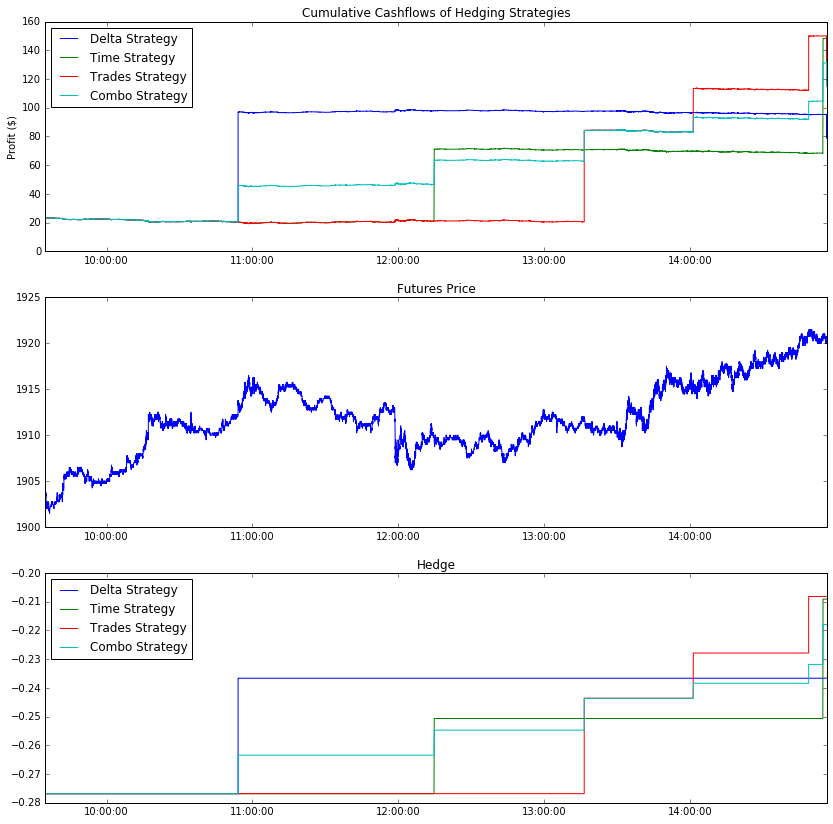

In [47]:
plt.figure(figsize=(14,14))
plt.subplot(311)
plt.title('Cumulative Cashflows of Hedging Strategies')
plt.ylabel('Profit ($)')
plt.plot(df.hedgeD_CF_cum)
plt.plot(df.hedgeM_CF_cum)
plt.plot(df.hedgeT_CF_cum)
plt.plot(df.hedgeC_CF_cum)
plt.legend(['Delta Strategy','Time Strategy','Trades Strategy','Combo Strategy'],loc='best')
plt.subplot(312)
plt.title('Futures Price')
plt.plot(df.Trade)
plt.subplot(313)
plt.title('Hedge')
plt.plot(df.hedgeD)
plt.plot(df.hedgeM)
plt.plot(df.hedgeT)
plt.plot(df.hedgeC)
plt.legend(['Delta Strategy','Time Strategy','Trades Strategy','Combo Strategy'],loc='best')

**As can be seen, the profitability of the strategy is quite dependent on the hedge value choice.  The futures price does not vary much in percentage compared to the hedge value, therefore the cashflows by-in-large are based on when we decide to hedge.  Indeed, the combination strategy hence delivers a profit around the average of the three main strategies.  Since we are short the put at 1860, the option is further out of the money as the futures price rises.  This means that the option 1860 put price will decrease over the day, so we will also make a profit on buying back the option at the end of the day.  Rising prices also goes hand in hand with less volatility than falling prices.  Therefore we will also do better on the hedge when prices are flat or rising.**

**We can look at how these different strategies perform as we vary ```D```, ```M``` and ```T```.  This can be done by putting the strategies into functions and looping through their parameters:**

In [14]:
def hedgeDelta(df,D):
    df['hedgeD'] = 0
    df['hedgeD'].ix[0] = df.delta[0]
    for i in range(1,len(df)):
        if np.abs(df.hedgeD[i-1] - df.delta[i]) > D:
            df.hedgeD[i] = df.delta[i]
        else:
            df.hedgeD[i] = df.hedgeD[i-1]
    df['hedgeD_CF'] = df.hedgeD*df.Trade - df.shift(1).hedgeD*df.shift(1).Trade
    df.hedgeD_CF.ix[0] = options[0]
    df['hedgeD_CF_cum'] = np.cumsum(df.hedgeD_CF)
    df.hedgeD_CF_cum.ix[-1] = df.hedgeD_CF_cum.ix[-1] - options[-1]
    return df.hedgeD_CF_cum.ix[-1]
    
def hedgeTime(df,M):
    df['time'] = df.index       
    df['timediff'] = (df.time - df.time.shift(1)).astype('timedelta64[ms]')
    df['cumdiff'] = np.cumsum(df.timediff)/1000/60//M
    df.cumdiff[df.cumdiff == df.cumdiff.shift(1)] = np.nan
    df['hedgeM'] = np.nan
    df['hedgeM'].ix[0] = df.delta[0]
    df.hedgeM[np.isnan(df.cumdiff) == False] = df.delta
    df.hedgeM = df.hedgeM.fillna(method='ffill')
    df['hedgeM_CF'] = df.hedgeM*df.Trade - df.shift(1).hedgeM*df.shift(1).Trade
    df.hedgeM_CF.ix[0] = options[0]
    df['hedgeM_CF_cum'] = np.cumsum(df.hedgeM_CF)
    df.hedgeM_CF_cum.ix[-1] = df.hedgeM_CF_cum.ix[-1] - options[-1]
    df = df.drop(['time','timediff','cumdiff'],1)
    return df.hedgeM_CF_cum.ix[-1]
    
def hedgeTrades(df,T):
    df['hedgeTpoint'] = np.where(df.index)[0]//T
    df.hedgeTpoint[df.hedgeTpoint == df.hedgeTpoint.shift(1)] = np.nan
    df['hedgeT'] = np.nan
    df['hedgeT'].ix[0] = df.delta[0]
    df.hedgeT[np.isnan(df.hedgeTpoint) == False] = df.delta
    df.hedgeT = df.hedgeT.fillna(method='ffill')
    df['hedgeT_CF'] = df.hedgeT*df.Trade - df.shift(1).hedgeT*df.shift(1).Trade
    df.hedgeT_CF.ix[0] = options[0]
    df['hedgeT_CF_cum'] = np.cumsum(df.hedgeT_CF)
    df.hedgeT_CF_cum.ix[-1] = df.hedgeT_CF_cum.ix[-1] - options[-1]
    df = df.drop(['hedgeTpoint'],1)
    return df.hedgeT_CF_cum.ix[-1]

**Let's first look at the delta strategy:**

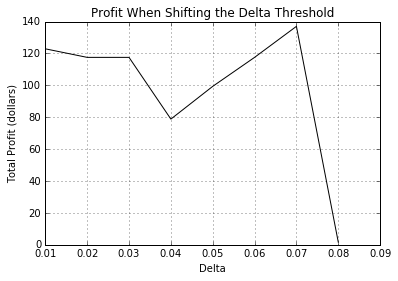

In [26]:
# check overall profit when varying the delta strategy
Perform_D = pd.DataFrame(columns = ['D','Cum_Profit'])
for D in range(1,9):
  D = D/100
  cum_profit = hedgeDelta(df,D)
  Perform_D = Perform_D.append(pd.DataFrame([[D,cum_profit]],columns=['D','Cum_Profit']),ignore_index=True)
plt.figure()
plt.plot(Perform_D.D,Perform_D.Cum_Profit,color='black')
plt.title('Profit When Shifting the Delta Threshold')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('Delta')
plt.grid() 

**The above chart suggests that a higher delta will yield a better profit, although profits are also quite high for a low ```D``` threshold.  In this case, setting ```D```=0.07 might be data mining, as there is a sharp drop of profits at ```D```=0.08.  Choosing ```D``` at something like 0.03 or 0.06 might be reasonable, as higher ```D``` reduces trading costs, though we still want to be decently hedged over time.**


**Next, we can look at the time strategy:**

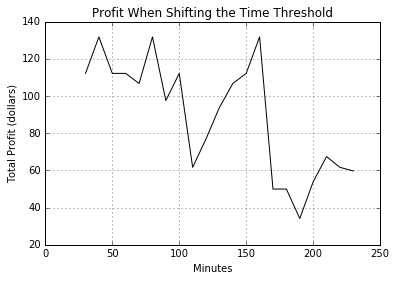

In [27]:
# check overall profit when varying the time strategy
Perform_M = pd.DataFrame(columns = ['M','Cum_Profit'])
for M in range(3,24):
  M = M*10
  cum_profit = hedgeTime(df,M)
  Perform_M = Perform_M.append(pd.DataFrame([[M,cum_profit]],columns=['M','Cum_Profit']),ignore_index=True)
plt.figure()
plt.plot(Perform_M.M,Perform_M.Cum_Profit,color='black') 
plt.title('Profit When Shifting the Time Threshold')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('Minutes')
plt.grid() 

**This chart suggests that best profits are produced by picking the time between hedging as 40, 80 or 160 minutes.  As expected, these are multiples of each other and this probably alludes to data mining.  A safe hedging region of ```T``` here appears to be between 40 and 80 minutes.  To save on trading costs, picking ```T``` around 60 to 80 minutes seems reasonable.**  


**Next, we look at the trades strategy:**

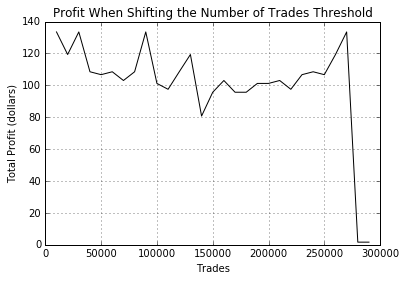

In [29]:
# check overall profit when varying the trade strategy
Perform_T = pd.DataFrame(columns = ['T','Cum_Profit'])
for T in range(1,30):
  T = T*10000
  cum_profit = hedgeTrades(df,T)
  Perform_T = Perform_T.append(pd.DataFrame([[T,cum_profit]],columns=['T','Cum_Profit']),ignore_index=True)
plt.figure()
plt.plot(Perform_T['T'],Perform_T.Cum_Profit,color='black') 
plt.title('Profit When Shifting the Number of Trades Threshold')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('Trades')
plt.grid() 

**This by far is the most stable approach of hedging.  Picking ```T``` at every 80000 to 130000 trades seems reasonable to maximise profit, while not over hedging the position.**


**We can now use the chosen levels of ```D```, ```M``` and ```T``` to see how the strategy would have performed on other days of the month.  This is done by turning all strategies into one function:**

In [48]:
# check final profits at each day with the strategies
dense_trade_prices = {}
dense_opt_prices = {}
dense_trade_prices['wk1'] = dense_trade_prices_wk1
dense_trade_prices['wk2'] = dense_trade_prices_wk2
dense_trade_prices['wk3'] = dense_trade_prices_wk3
dense_trade_prices['wk4'] = dense_trade_prices_wk4
dense_trade_prices['wk5'] = dense_trade_prices_wk5
dense_opt_prices['wk1'] = dense_opt_prices_wk1
dense_opt_prices['wk2'] = dense_opt_prices_wk2
dense_opt_prices['wk3'] = dense_opt_prices_wk3
dense_opt_prices['wk4'] = dense_opt_prices_wk4
dense_opt_prices['wk5'] = dense_opt_prices_wk5

def allStrats(w,d):
    options = dense_opt_prices['wk'+str(w)][(dense_opt_prices['wk'+str(w)].index.day == d) & (dense_opt_prices['wk'+str(w)].index.time >= datetime.time(8,45,0,0)) & (dense_opt_prices['wk'+str(w)].index.time <= datetime.time(15,0,0,0))]
    df = dense_trade_prices['wk'+str(w)][(dense_trade_prices['wk'+str(w)].index.day == d) & (dense_trade_prices['wk'+str(w)].index >= datetime.datetime.fromtimestamp(options.index[0].timestamp())) & (dense_trade_prices['wk'+str(w)].index <= datetime.datetime.fromtimestamp( options.index[-1].timestamp()))]
    df = pd.DataFrame(df)
    df['sig'] = owf.ix['2014-10-'+str(d)].AtM # at the money vol
    df['tau'] = owf.ix['2014-10-'+str(d)].DtE/365 # time to maturity
    df['rf'] = rf.ix['2014-10-'+str(d)].Value/100 # risk free rate
    df['d1'] = (np.log(df.Trade/K) + df.tau*(df.rf+0.5*df.sig**2))/(df.sig*np.sqrt(df.tau))
    df['delta'] = norm.cdf(df.d1) - 1 # for hedging
    df['hedgeD'] = 0 # set 0 column
    df['hedgeD'].ix[0] = df.delta[0] # initially hedge option at first delta
    for i in range(1,len(df)):
        if np.abs(df.hedgeD[i-1] - df.delta[i]) > D: # if delta of new trade is different enough from current hedging delta
            df.hedgeD[i] = df.delta[i] # re-hedge using new delta
        else:
            df.hedgeD[i] = df.hedgeD[i-1] # keep old delta
    df['hedgeD_CF'] = df.hedgeD*df.Trade - df.shift(1).hedgeD*df.shift(1).Trade # PnL between trades
    df.hedgeD_CF.ix[0] = options[0] # money by selling option
    df['hedgeD_CF_cum'] = np.cumsum(df.hedgeD_CF) # cumulative cash flows
    df.hedgeD_CF_cum.ix[-1] = df.hedgeD_CF_cum.ix[-1] - options[-1] # money by buying option
    df['time'] = df.index # create time column from index    
    df['timediff'] = (df.time - df.time.shift(1)).astype('timedelta64[ms]') # find difference in time of trades
    df['cumdiff'] = np.cumsum(df.timediff)/1000/60//M # mark where M minutes have passed
    df.cumdiff[df.cumdiff == df.cumdiff.shift(1)] = np.nan # remove other cumdiff values that don't mark anything
    df['hedgeM'] = np.nan # set empty column
    df['hedgeM'].ix[0] = df.delta[0] # initially hedge option at first delta
    df.hedgeM[np.isnan(df.cumdiff) == False] = df.delta # place delta at markers
    df.hedgeM = df.hedgeM.fillna(method='ffill') # fill delta until delta changes
    df['hedgeM_CF'] = df.hedgeM*df.Trade - df.shift(1).hedgeM*df.shift(1).Trade # PnL between trades
    df.hedgeM_CF.ix[0] = options[0]  # money by selling option
    df['hedgeM_CF_cum'] = np.cumsum(df.hedgeM_CF) # cumulative cash flows
    df.hedgeM_CF_cum.ix[-1] = df.hedgeM_CF_cum.ix[-1] - options[-1] # money by buying option
    df['hedgeTpoint'] = np.where(df.index)[0]//T # number the trades and find every T'th modulo
    df.hedgeTpoint[df.hedgeTpoint == df.hedgeTpoint.shift(1)] = np.nan  # remove other values that don't mark anything
    df['hedgeT'] = np.nan # set empty column
    df['hedgeT'].ix[0] = df.delta[0] # initially hedge option at first delta
    df.hedgeT[np.isnan(df.hedgeTpoint) == False] = df.delta # place delta at markers
    df.hedgeT = df.hedgeT.fillna(method='ffill')  # fill delta until delta changes
    df['hedgeT_CF'] = df.hedgeT*df.Trade - df.shift(1).hedgeT*df.shift(1).Trade # PnL between trades
    df.hedgeT_CF.ix[0] = options[0] # money by selling option
    df['hedgeT_CF_cum'] = np.cumsum(df.hedgeT_CF) # cumulative cash flows
    df.hedgeT_CF_cum.ix[-1] = df.hedgeT_CF_cum.ix[-1] - options[-1] # money by buying option
    df['hedgeC'] = (df.hedgeD + df.hedgeM + df.hedgeT)/3 # combination of hedge strategies
    df['hedgeC_CF'] = df.hedgeC*df.Trade - df.shift(1).hedgeC*df.shift(1).Trade # PnL between trades
    df.hedgeC_CF.ix[0] = options[0] # money by selling option
    df['hedgeC_CF_cum'] = np.cumsum(df.hedgeC_CF) # cumulative cash flows
    df.hedgeC_CF_cum.ix[-1] = df.hedgeC_CF_cum.ix[-1] - options[-1] # money by buying option
    df = df.drop(['time','timediff','cumdiff','hedgeTpoint'],1) # remove unnecessary columns
    return w,d,df.hedgeD_CF_cum[-1],df.hedgeM_CF_cum[-1],df.hedgeT_CF_cum[-1],df.hedgeC_CF_cum[-1]

**Now let's run the daily results:**

In [49]:
Profits = pd.DataFrame(columns=['Week','Day of Month','Delta_Profit','Time_Profit','TradeNum_Profit','Combo_Profit'])
Profits.loc[1] = allStrats(1,29)
Profits.loc[2] = allStrats(2,6)
Profits.loc[3] = allStrats(2,7)
Profits.loc[4] = allStrats(2,8)
Profits.loc[5] = allStrats(3,13)
Profits.loc[6] = allStrats(4,20)
Profits.loc[7] = allStrats(4,21)
Profits.loc[8] = allStrats(5,27)
Profits.loc[9] = allStrats(5,28)
print(Profits)

   Week  Day of Month  Delta_Profit  Time_Profit  TradeNum_Profit  Combo_Profit
1     1            29      1.386255     1.386255         1.386255      1.386255
2     2             6     -0.668024    -0.668024       -12.775678     -4.703909
3     2             7     -0.347280    -0.347280       -12.509665     -4.401408
4     2             8      0.145644     0.145644       -23.693993     -7.800902
5     3            13    -77.871337    -1.528679       -83.544364    -54.314793
6     4            20      1.579245   -38.121686       -26.139603    -20.894015
7     4            21     78.851544   131.767803       133.521917    114.713754
8     5            27     -0.314998    -0.314998       -28.289841     -9.639946
9     5            28     -0.179022   -15.302189        -3.585840     -6.355684


**It appears that the parameters picked are only really beneficial for the day used to pick them!  Calibrating the parameters to be profitable for out of sample data indeed would be very difficult, and would require deeper knowledge of the interaction between E-mini futures, options and hedging.**  